# Carrier Tracking

This notebook is a continuation of the Complex_Wave notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

# Function to quickly create a wave

In [2]:
def makWav(freqHz, phaseDeg, samples, fs = 4.092*10**6):
    #Initialize terms
    freq = np.exp(1j * 2 * np.pi * (freqHz/fs))
    
    pOffset = np.deg2rad(phaseDeg) 

    phase = np.exp(1j * pOffset)

    #Init samples
    wav = np.zeros(samples, dtype = 'complex')

    
    for n, w in enumerate(wav):
        wav[n] = phase
        phase = phase * freq
    
    return wav

# Signal with two SVs

We will create two signals to practice on. The first will be a signal from satellite 15 that has a doppler shift of 6000 Hz. The other will be satellite 10 with a doppler shift of 1000 Hz.

We are going to assume the Code phase remains locked, and the carrier doppler shift does not change and see if the loop locks on.

In [96]:
Nsamp = 40000

carr1 = makWav(6000, 0, Nsamp)
carr2 = makWav(1000, 0, Nsamp)

sat = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
           (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
           (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
           (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]

CodeGen1 = GoldCode(sat[14]) #SV 15
CodeGen2 = GoldCode(sat[9]) #SV 10

code1 = CodeGen1.getCode(int(Nsamp/4), samplesPerChip = 4)
code2 = CodeGen2.getCode(int(Nsamp/4), samplesPerChip = 4)

signal1 = carr1 * code1
signal2 = carr2 * code2

signalboth = signal1 + signal2


/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


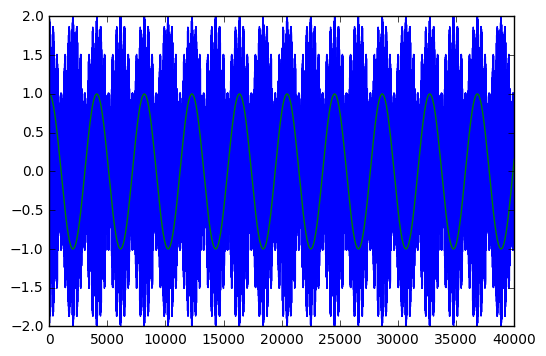

In [97]:
plt.plot(signalboth)
plt.plot(carr2)
plt.show()

# Multiply code 1 to pop out carrier



/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


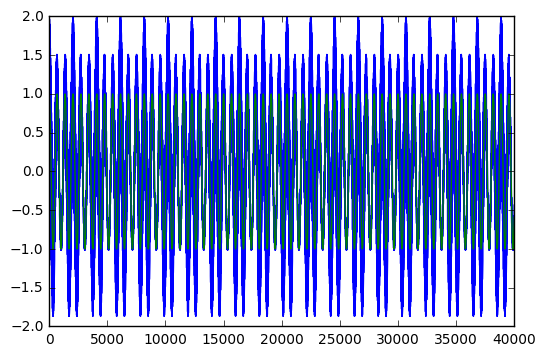

In [98]:
pop1 = signalboth * code1

plt.plot(pop1)
plt.plot(carr1)
plt.show()

In [161]:
zeta = .15
bandwidth = 125#10
k = .025#222.25#1100
interval=10

wn = bandwidth * 8 * zeta /\
    (4 * zeta ** 2 + 1)
    
t1 = k / (wn * wn)
t2 = (zeta * 2.0) / wn

fs = 4.092*10**6 # Sampling Frequency [Hz]

print(wn)
print(t1)
print(t2)
print()
print(t2/t1)
print(.001/t2)
print((1/fs)/t2)

137.61467889908255
1.3201111111111117e-06
0.00218

1651.3761467889901
0.4587155963302752
0.00011210058561345926


In [162]:
#set the signal

signal = pop1
fs = 4.092*10**6 # Sampling Frequency [Hz]
interval = 1/fs #Summation interval
LObase = 6010 #base frequency of Local Oscillator

#Local Oscillator output
LOout = np.zeros(len(pop1), dtype='complex')

#Log the discriminator and LO frequency
discVec = np.zeros(len(pop1))
LOFreq = np.zeros(len(pop1))

LOout[0] = 1 + 0j #Initial phase of LO

#Initialize
adjustment = 0
oldErr = 0
oldRef = 0

for n, s in enumerate(signal):
    #Check difference
    mixed = signal[n]/LOout[n]
    
    #Calculate discriminator
    d = np.arctan(np.imag(mixed)/np.real(mixed)) / (2*np.pi)
    discVec[n] = d #Save discriminator
    
    #Filter result and adjust frequency
    adjustment = oldRef + (d - oldErr) * (t2/t1) + d * (interval/t2)#(interval/t2)#* (7000) + d * 20    
    refFreq = LObase +  adjustment     
    
    oldRef = adjustment
    oldErr = d
    
    LOFreq[n] = refFreq
    
    #Calculate next reference frequency sample
    if (n<len(signal)-1):
        LOout[n + 1] = LOout[n] * np.exp(1j * 2 * np.pi * (refFreq/fs))

In [157]:
#Filter LO frequency
bsize = 4000
filteredLOFilter = np.zeros(bsize)
filteredLOFreq = np.zeros(len(signal))
for q in range(len(signal)):
    filteredLOFilter[q % bsize] = LOFreq[q]
    filteredLOFreq[q] = sum(filteredLOFilter)/np.count_nonzero(filteredLOFilter)

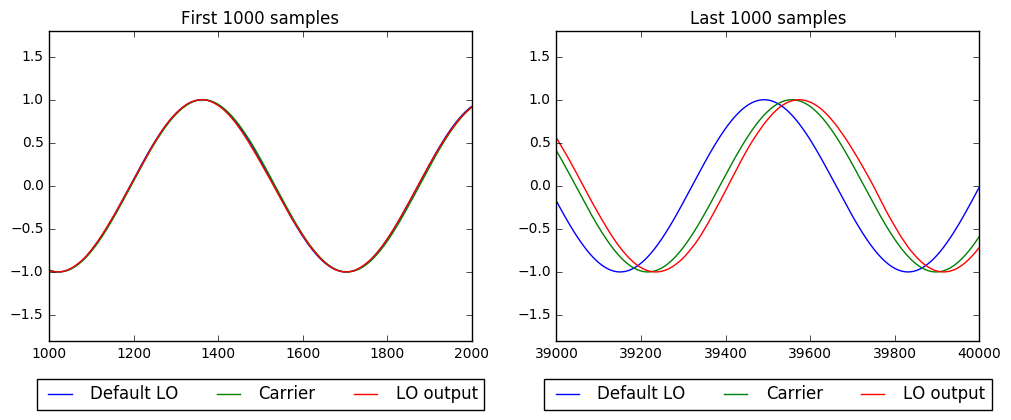

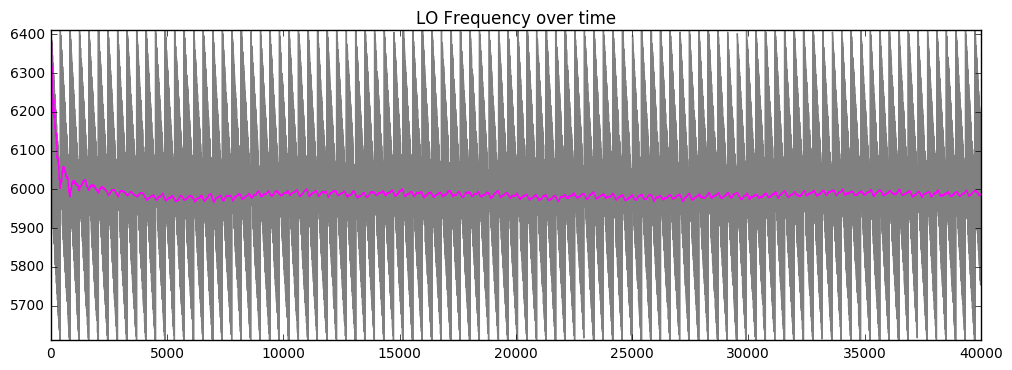

In [167]:
#Make a signal representing a LO without feedback
LODefault = makWav(LObase, 0, len(signal))

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
xax = range(1000, 2000)
plt.plot(xax, np.real(LODefault)[1000:2000], label = 'Default LO')
plt.plot(xax, np.real(carr1)[1000:2000], label = 'Carrier')
plt.plot(xax, np.real(LOout)[1000:2000], label = 'LO output')
plt.ylim([-1.8, 1.8])
plt.title("First 1000 samples")

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.25),
          ncol=3)

plt.subplot(1,2,2)
xax = range(len(signal)-1000, len(signal))

plt.plot(xax, np.real(LODefault)[-1001:-1], label = 'Default LO')
plt.plot(xax, np.real(carr1)[-1001:-1], label = 'Carrier')
plt.plot(xax, np.real(LOout)[-1001:-1], label = 'LO output')
plt.ylim([-1.8, 1.8])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.25),
          ncol=3)

plt.title("Last 1000 samples")
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(LOFreq, color = 'gray')
plt.plot(filteredLOFreq, color = 'magenta')
plt.ylim([LObase-400, LObase+400])
plt.title("LO Frequency over time")
plt.show()



In [168]:
#Demodulate using LO

#Multiplying the raw signal with the output of the LO "should" give us the code
codeSig = signalboth * np.conj(LOout)

#Ip should be close to 10000 and Qp should be at least a power of 10 smaller
Ip = np.sum(code1*np.real(codeSig))
Qp = np.sum(code1*np.imag(codeSig))

print(Ip)
print(Qp)

print()
#Print frequency mean after first 1000 samples of settling
np.mean(filteredLOFreq[2000::])


39596.2975478
1869.87715912



5985.4813781715311

In [160]:
data = IQData()

# Need these to pass to importFile module
fs = 4.092*10**6 # Sampling Frequency [Hz]
NumberOfMilliseconds = 10
SampleLength = NumberOfMilliseconds*10**(-3)
BytesToSkip = 100000

data.importFile('../resources/test.max', fs, SampleLength, BytesToSkip)
#data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)


Opening a file.
File handle is: 67.
Total Samples to read: 40920
Total Bytes read: 20460.
Which equals 40920 IQ pairs.
Sample Length: 0.010000 seconds.
File is now closed.
